# DT2470 Lab 04: Shazam Wow!

by Bob L. T. Sturm

In this lab you will build and test a music fingerprinting system, similar to how Shazam does it – or at least as described in 2003: A. Wang, “An industrial strength audio search algorithm,” in Proc. Int. Soc. Music Info. Retrieval, Oct. 2003. Our approach is illustrated below. First we will take an audio signal and compute its time-frequency representation, or sonogram. Then we will strategically find several points of interest in that representation. For each of those points we will construct tuples using other points of interest in the sonogram. These will become hashes that describe the fingerprint of the audio signal.

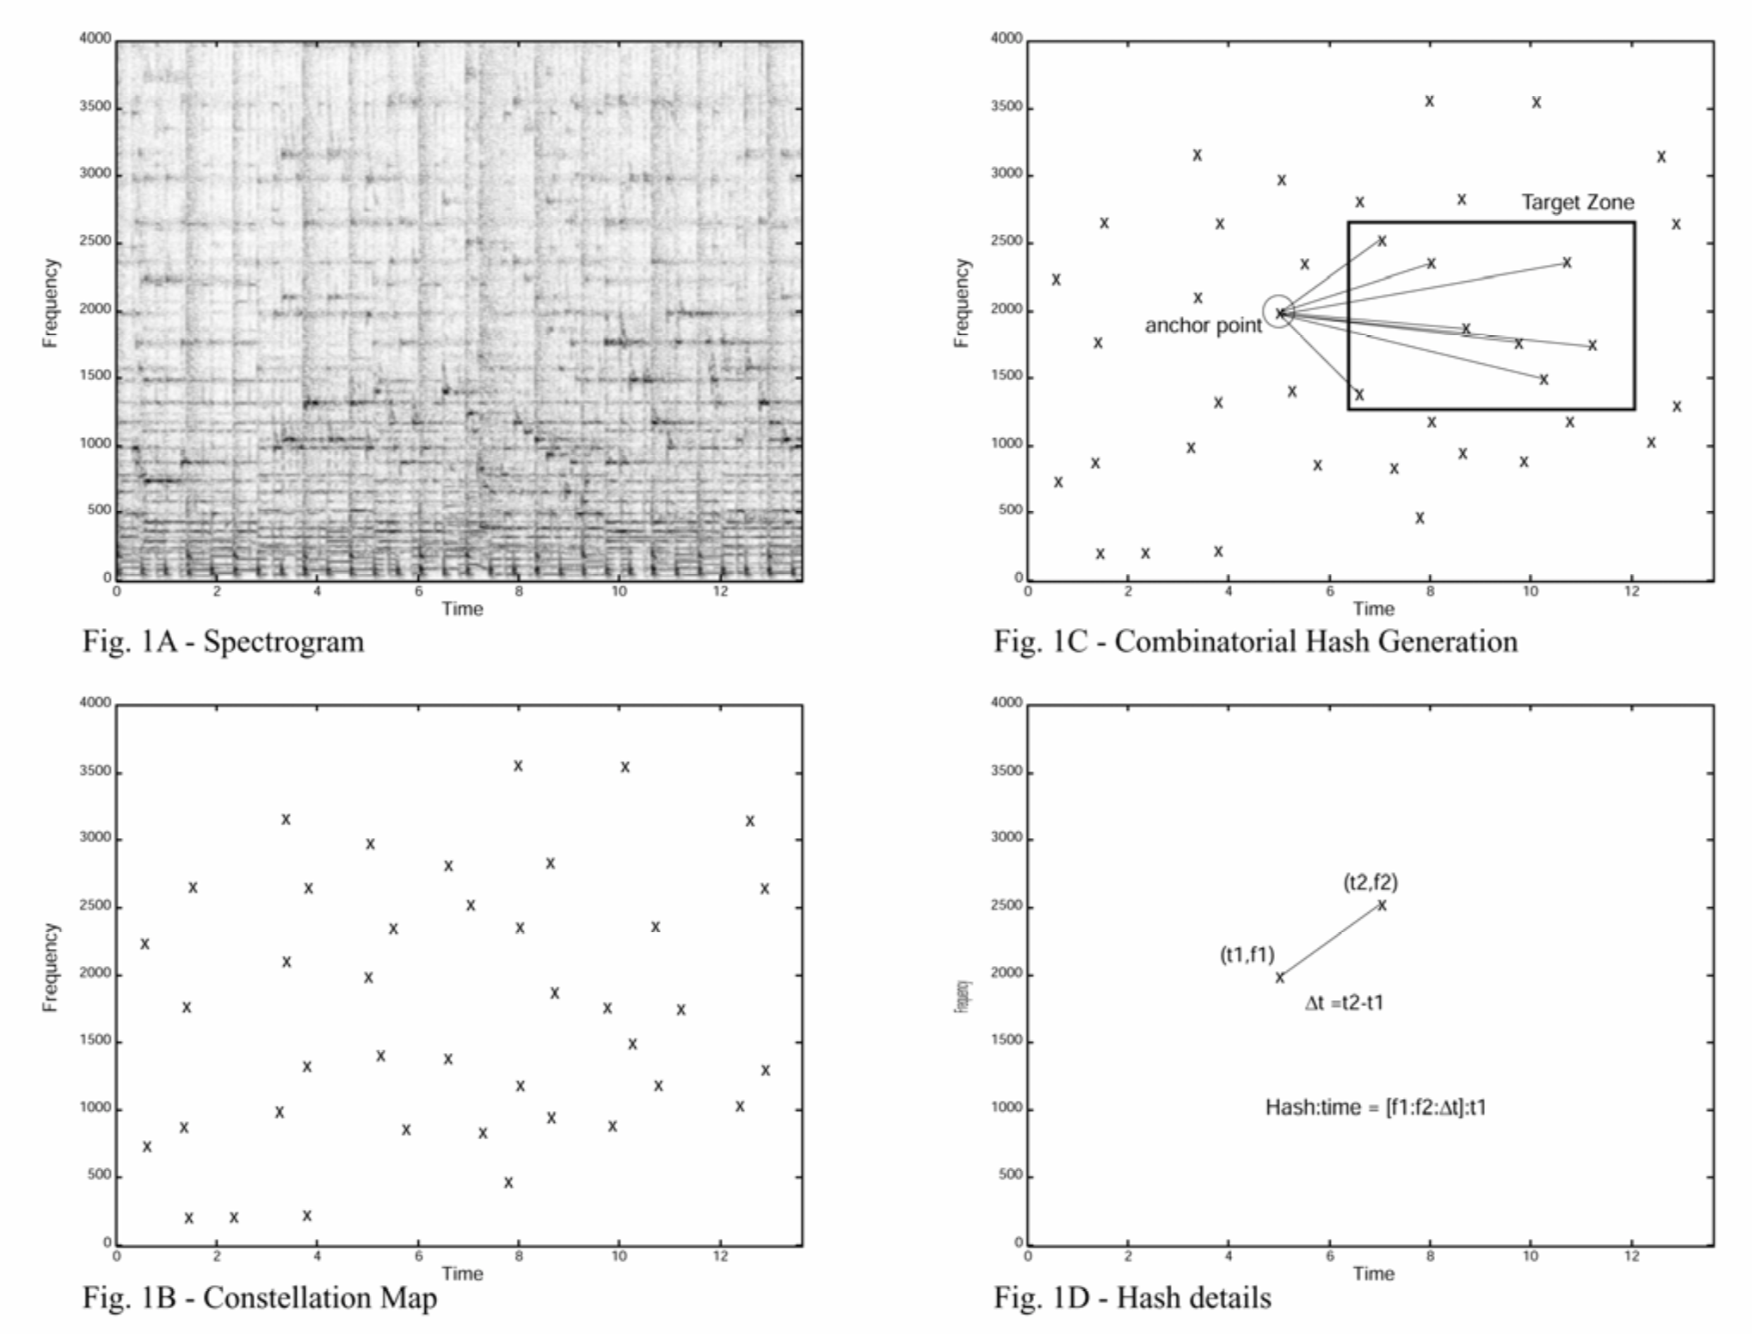

In the first part, you will gradually build said fingerprint creation system.

In the second part, you will build an algorithm that compares fingerprints.

The lab report you submit should be a testament to your intelligence, as well as a reflection of your willingness to be a part of this module. You are free to use whatever software you want, e.g., MATLAB, Processing, etc. But below I use python. See the first lab and its solutions for assistance.

I also include some images so you can confirm whether you are on the right track, or just to have a brief pause to laugh at how far your answer is from being correct.

# Part 1: Creating audio fingerprints

## 1.1 

Pick one of the query sound files and compute its dB magnitude short-time Fourier transform using a Hann window of duration 50 ms with a window hopsize of 10 ms, and zeropadding to four times the length of the window. Plot said sonogram, and appropriately label your axes with "Frequency (kHz)" and "Time (s)". The frequency axis must be in kiloHertz, and limited 0 to 5000 Hz. The time axis must be in seconds. Choose a colormap that you feel describes your personality (https://matplotlib.org/3.1.1/tutorials/colors/colormaps.html).


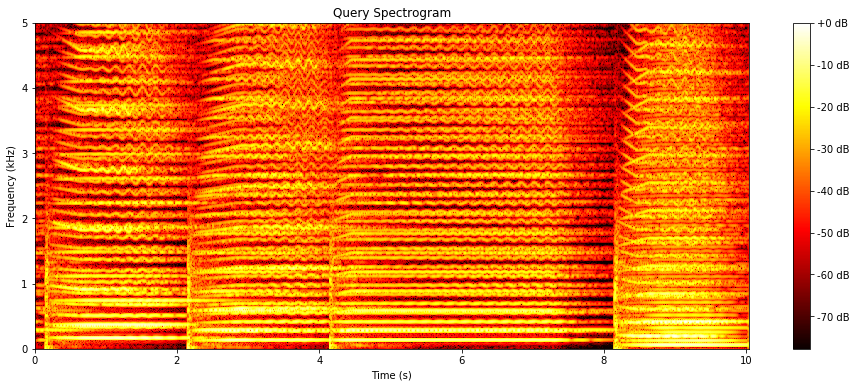

In [1]:
# add your code below

import pydub
import matplotlib.pyplot as plt
import numpy as np
import librosa
import scipy.signal

windowSize = 50
hopSize = 10

data, sampleRate = librosa.load("queries/Q1.wav")

# Set plot sizes and quality
plt.rcParams['figure.figsize'] = [16, 6]

# size parameters are in ms
def stftSpectrogram(yVals, windowSize, hopSize):
    yVals = yVals - np.mean(yVals)
    samplesPerMs = sampleRate // 1000
    freqs, times, D = scipy.signal.stft(yVals, fs=sampleRate, window='hann', 
                                        nperseg=int(samplesPerMs*windowSize), 
                                        noverlap=int(samplesPerMs*(windowSize-hopSize)), 
                                        nfft=int(4*samplesPerMs*windowSize))
    DMagnitudes = np.abs(D)
    db = librosa.amplitude_to_db(DMagnitudes, ref=np.max)
    
    return freqs, times, db
    
    
def plotSpectrogram(times, freqs, db, title, points=None):
    plt.pcolormesh(times, freqs / 1000, db, shading='auto', cmap="hot")
    plt.colorbar(format='%+2.0f dB')

    if points is not None:
        plt.plot(points[:, 0], points[:, 1] / 1000, 'x', color="black", label="Anchor")
        plt.legend()

    plt.ylim([0, 5])
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (kHz)")
    plt.title(title)
    plt.show()
    
    
    
freqs, times, db = stftSpectrogram(data, windowSize, hopSize)
plotSpectrogram(times, freqs, db, "Query Spectrogram")

# 1.2 

We are now going to locate in this sonogram "anchors", or points of interest. We will take a rather naive approach: for each continguous ΔTxΔF box, find the time and frequency with the largest energy. Let's make ΔT=100 ms, and ΔF be such that it divides the whole spectrum $[0,F_s/2]$ into 25 bands. For each one of these segments, locate the time and frequency of the largest value, as well as its dB. Do this for the sonogram you created in the last question.


In [2]:
# add your code below

def setAnchors(data, sampleRate, freqs, times, db):

    nq = sampleRate / 2

    dT = 0.100
    dF = nq / 25

    timeLen = len(data) / sampleRate
    timeLen = np.floor(timeLen / dT) * dT  # Remove frames that do not fit


    # List of frames, each containing a list with frequency indices that go into this frame
    timeFrames = []
    for t in np.arange(0, timeLen, dT):
        # Upper limit for time
        ulT = t + dT
        idxs = np.where((t <= times) & (times < ulT))[0]
        timeFrames.append(idxs)

    # List of frames, each containing a list with frequency indices that go into this frame
    freqFrames = []
    for f in np.arange(0, nq, dF):
        # Upper limit for freq
        ulF = f + dF
        idxs = np.where((f <= freqs) & (freqs < ulF))[0]
        freqFrames.append(idxs)

    timeFrames = np.array(timeFrames)
    freqFrames = np.array(freqFrames)


    # Points Of Interest
    poi = []
    for tIdxs in timeFrames:
        for fIdxs in freqFrames:
            # Extract index intervals instead of all indices
            llt = tIdxs[0]
            ult = tIdxs[-1]+1
            llf = fIdxs[0]
            ulf = fIdxs[-1]+1

            # Numpy to find max value and position
            maxVal = np.max(db[llf:ulf, llt:ult])
            maxPoint = np.where(db[llf:ulf, llt:ult] == maxVal)
            maxPoint = [maxPoint[0][0] + llf, maxPoint[1][0] + llt]
            
            maxFreqIdx = maxPoint[0]
            maxTimeIdx = maxPoint[1]
            poi.append([times[maxTimeIdx], freqs[maxFreqIdx]])

    poi = np.array(poi)
    return poi


## My Notes

First I group all the indices in each dimension into their slices. Then I iterate through these to find the maximum value of each frame. I have not put much time into numpy optimizing it. So it is rather slow, but still feasible for this task. 

3.  With the anchors you found in the previous question, superimpose them on the sonogram. Write something intelligent about the results. My figure appears below, with each anchor marked by an "x".

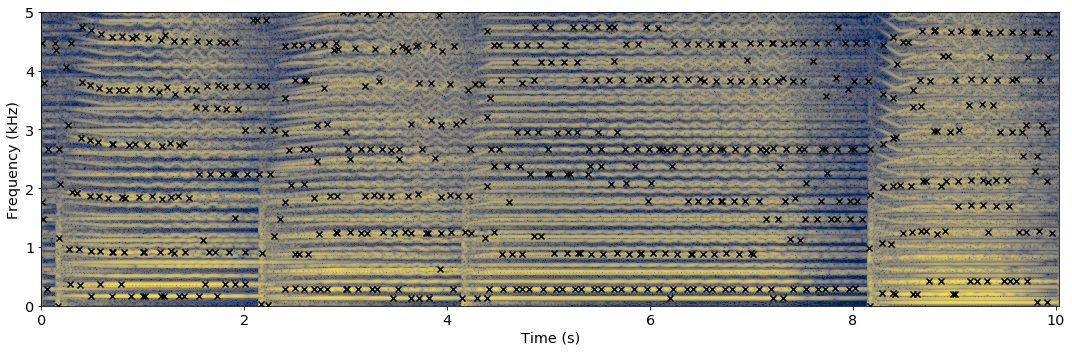

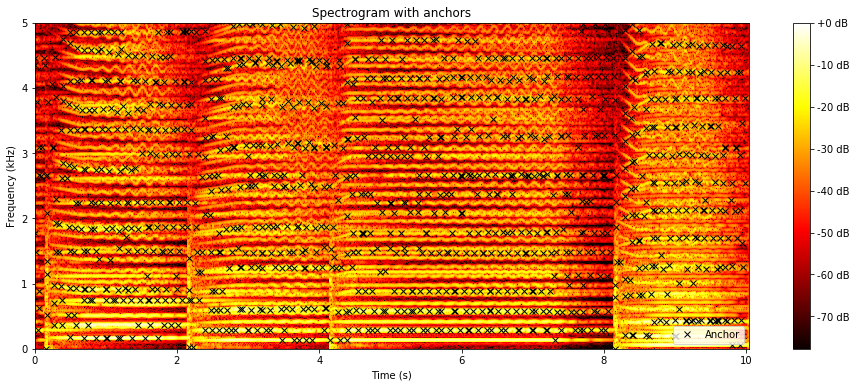

In [3]:
# add your code below
anchors = setAnchors(data, sampleRate, freqs, times, db)
plotSpectrogram(times, freqs, db, "Spectrogram with anchors", points=anchors)

## My Intelligent Notes

We can see that the points "follow" the bright areas of high energy. 

## 1.3

Now it's time to compute hashes from a set of anchors. A *hash* is a tuple describing an anchor at time ($t_1$) and its relationship to another anchor at time ($t_2$). A Shazam hash is the tuple $(f_1,f_2,∆t_{12})$, which contains the frequencies of both anchors ($f_1$,$f_2$), and the difference in their time positions ($∆t_{12} = t_2-t_1$). The Shazam fingerprint of an audio signal is then the set of hashes extracted from it as well as times at which each hash appears. To create these hashes, Shazam does not look at all pairs of anchors. For a given anchor, it computes hashes using anchors in a "target zone". Define the target zone of an anchor as a time-frequency region 100 ms after $t_1$, spanning 500 ms, and spanning frequencies one half-octave above and below $f_1$. For instance, for an anchor with $t_1$ and $f_1$, its target zone is located between $t_1+100$ ms and $t_1+100+500$ ms, and spans a frequency range of $f_12^{-0.5}$ and $f_12^{0.5}$. Compute all the hashes for your choosen query signal, in the form $(f_1,f_2,∆t_{12})$. Your final data structure representing a fingerprint $F$ should be something like a sequence of times paired with hashes $F = ((\tau_1, h_1), (\tau_2, h_2), \ldots)$, where $\tau_1$ is the time at which hash $h_1$ occurs, etc.

In [4]:
# add your code below

def findTargetAnchors(a, anchors):
    t, f = a
    times = anchors[:, 0]
    freqs = anchors[:, 1]
    llt = t + 0.100
    ult = t + 0.600
    llf = f * np.power(2, -0.5)
    ulf = f * np.power(2, 0.5)
    
    tIdxs = np.where((llt <= times) & (times < ult))[0]
    fIdxs = np.where((llf <= freqs) & (freqs < ulf))[0]
    
    targetsIdxs = np.intersect1d(tIdxs, fIdxs)
    
    if len(targetsIdxs) == 0:
        return []
    
    targets = anchors[targetsIdxs]
    return targets


def hashFunc(a1, a2):
    return np.array([a1[1], a2[1], a2[0] - a1[0]])


def fingerprint(anchors):
    fp = []
    for a in anchors:
        targetAnchors = findTargetAnchors(a, anchors)
        
        for target in targetAnchors:
            h = hashFunc(a, target)
            fp.append([a[0], h])
            
    return fp


fp = fingerprint(anchors)

# Part 2: Comparing fingerprints

## 2.1 

Now it's time to create an algorithm for comparing two fingerprints. We will start simple to make sure things work. Extract any 1-second segment of from the audiofile you worked with above and compute its fingerprint $F_q$ as above. ("q" is for "query".) Now for each hash in $F_q$, find all matching hashes in $F_q$, and store the times of the matches. To compare two hashes, compute the sum of the magnitude differences between the dimensions of the hashes. For instance, if I have these hashes, $(a,b,c)$ and $(d,e,f)$, I just compute the following value: $d = |(a-d)|+|(b-e)|+|(c-f)|$. If $d=0$ then it's a match! Create a scatter plot of the times of the matching hashes. Write something about what you see, and why you see it. Not why you see it, but *why* you see the properties you see in this particular plot. My plot looks like this: 

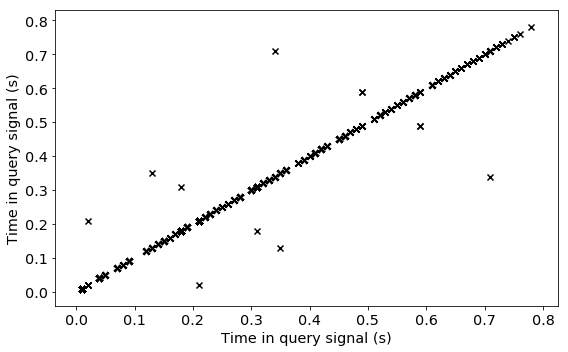



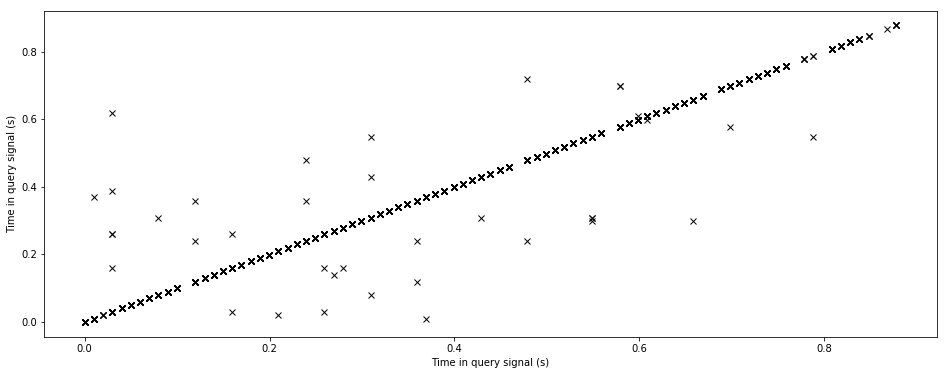

In [5]:
##### add your code below

def soundToFingerprint(data, sampleRate):
    freqs, times, db = stftSpectrogram(data, windowSize, hopSize)
    anchors = setAnchors(data, sampleRate, freqs, times, db)
    return np.array(fingerprint(anchors))

def compareHashes(h1, h2):
    return np.sum(np.abs(h1 - h2), axis=1)

def compareFingerprints(fp1, fp2):
    matches = []
    hashes1 = np.vstack(fp1[:, 1])
    hashes2 = np.vstack(fp2[:, 1])
    
    times1 = fp1[:, 0]
    times2 = fp2[:, 0]
    
    for idx, h1 in enumerate(hashes1):
        hashDiff = compareHashes(h1, hashes2)
        matchIdxs = np.where(hashDiff == 0)[0]
        if len(matchIdxs) > 0:
            idxChosen = np.random.choice(matchIdxs)
            matches.append([times1[idx], times2[idxChosen]])
    
    matches = np.array(matches)
    return matches[:, 0], matches[:, 1]
        

startTime = 1
fragment = data[int(startTime*sampleRate) : int((startTime+1) * sampleRate)]
fp = soundToFingerprint(fragment, sampleRate)
m1, m2 = compareFingerprints(fp, fp)

plt.plot(m1, m2, "x", color="black")
plt.xlabel("Time in query signal (s)")
plt.ylabel("Time in query signal (s)")
plt.show()

## My Notes

For many of the hashes in the query array, there are multiple matches in the other array. If I take the first or last matching index, I will find points beneath or above the matching line respectively. To get a plot as similar as possible to the example plot (and possibly make the program more robust), I take a random choice. 

Of course, for execution time performance, one would instead rely on a find operation that stops searching after finding a first match. 

## 2.2 

Now compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of the original audiofile. ("d" is for "document") Again make a scatter plot of the times of the matches. As above, write something about the results.

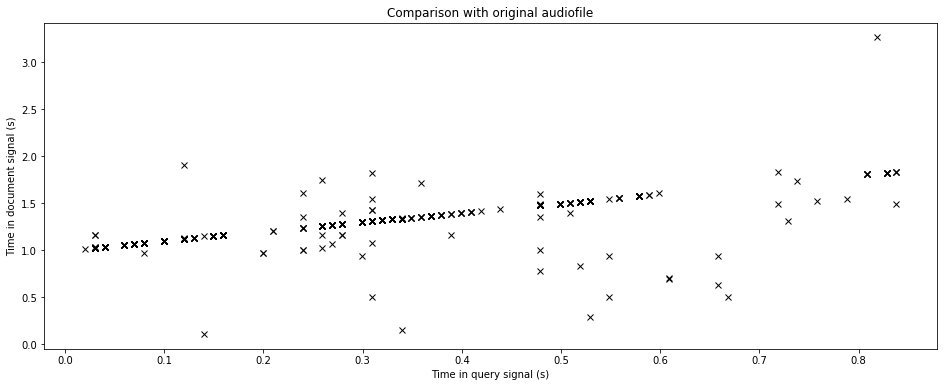

In [6]:
# add your code below

fpQ = soundToFingerprint(fragment, sampleRate)
fpD = soundToFingerprint(data, sampleRate)

m1, m2 = compareFingerprints(fpQ, fpD)

plt.plot(m1, m2, "x", color="black")
plt.xlabel("Time in query signal (s)")
plt.ylabel("Time in document signal (s)")
plt.title("Comparison with original audiofile")
plt.show()

## My Notes

We see a strong similarity in the straight line that is forming with many matching points here. This is because the audios are indeed matching. The query fragment used is a 1-second slice of the original file starting from second 1. It is clear from this plot that the query matches quite well with the 1s - 2s region of the original file. 

## 2.3 

Finally compare $F_q$ with $F_d$, where $F_d$ is the fingerprint of a *different* audiofile. Again make a scatter plot of the times of the matches. As above, write something about the results, and in particular compare with the plot produced in the l

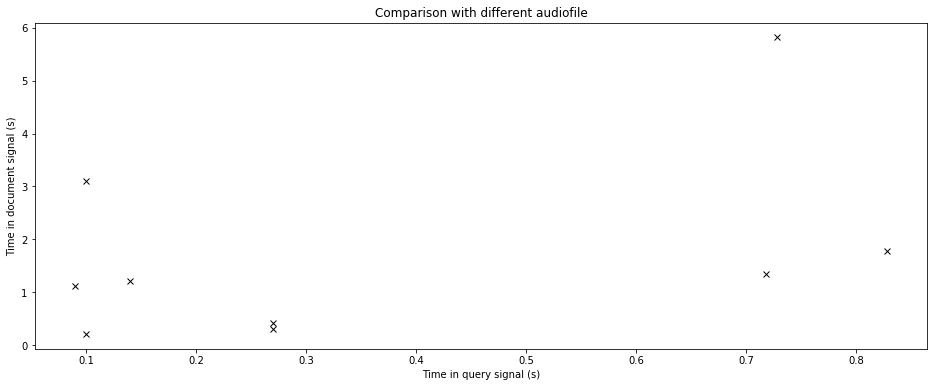

In [7]:
# add your code below

dataD, sampleRateD = librosa.load("queries/Q2.wav")

fpQ = soundToFingerprint(fragment, sampleRate)
fpD = soundToFingerprint(dataD, sampleRateD)

m1, m2 = compareFingerprints(fpQ, fpD)

plt.plot(m1, m2, "x", color="black")
plt.xlabel("Time in query signal (s)")
plt.ylabel("Time in document signal (s)")
plt.title("Comparison with different audiofile")
plt.show()

## My Notes

Here, instead, we see a strong mismatch, as we have almost no matching points. And the few hashes that do match, lie spread out almost in a random manner in the time domains. To use this in an application, one could make the predictions based on both how many matches that is found and the structure of them (i.e. if they form a straight line that makes sense), perhaps by doing linear regression and compare the MSE. It would be interesting to learn more about how to do this can be done in a more efficient way, by comparing less hashes, optimizing the code, and placing the anchor points in a more sophisticated way. 

I am not sure if we were supposed to use the KikiBoubaData here, but the execution times are quite long with just the queries here. And I do not know which files the queries correspond to (this seems to be the project idea below). 

It was interesting to see how Shazam works, even if this task is simplified. 

# *2.4

Here's a project idea: Write a program to locate the files in the kiki-bouba collection from which all these queries come.